In [1]:
import os
# needs to be set for matplotlib and seaborn
os.environ['LANG'] = 'en_US.UTF-8'
os.environ['LC_ALL'] = 'en_US.UTF-8'
sc.install_pypi_package('matplotlib', 'https://pypi.org/simple')
sc.install_pypi_package('pandas==0.25.1')
sc.install_pypi_package('seaborn')
sc.install_pypi_package('stop_words')
sc.install_pypi_package('wordcloud')
sc.install_pypi_package('TextBlob')
sc.install_pypi_package('nltk')

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1586874848311_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)
  Using cached kiwisolver-1.2.0-cp36-cp36m-manylinux1_x86_64.whl (88 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

  Using cached pandas-0.25.1-cp36-cp36m-manylinux1_x86_64.whl (10.5 MB)

  Using cached seaborn-0.10.0-py3-none-any.whl (215 kB)
  Using cached scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl (26.1 MB)

Processing /mnt/var/lib/livy/.cache/pip/wheels/61/13/fb/bde87253355995b963f6355ca563a614453668bfc1b44fdc54/stop_words-2018.7.23-py3-none-any.whl

  Using cached wordcloud-1.6.0-cp36-cp36m-manylinux1_x86_64.whl (361 kB)
  Using cached Pillow-7.1.1-cp36-cp36m-manylinux1_x86_64.whl (2.1 MB)

  Using cached textblob-0.15.3-py2.py3-none-any.whl (636 kB)


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark import sql, SparkConf, SparkContext
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk import sent_tokenize, word_tokenize
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib
from textblob import TextBlob
from pyspark.sql import Row

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
sc = SparkContext.getOrCreate()
sqlContext = sql.SQLContext(sc)
stop_words = list(get_stop_words('en')) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
def pre_process_data(data_str):
    stop_words.append('none')
    data_tokens = data_str.split(' ')
    # remove stopwords
    filtered_data = [data for data in data_tokens if not data in stop_words]
    # remove short words and numbers
    cleaned_data = [data for data in filtered_data if (len(data) > 2 and not data.isnumeric())]
    return cleaned_data

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
def get_topN_freq(data, topN):
    freq_dist = nltk.FreqDist(data)
    topN_data = freq_dist.most_common(topN)
    return topN_data

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
def get_polarity_rdd_column_string(df,column_title):
    data_list = list(df.select(column_title).rdd.flatMap(lambda x: x).collect())
    blob_list = []
    column_string = ''
    for data in data_list:
        column_string = column_string+' '+ str(data).lower()
        blob = TextBlob(str(data))
        blob_list.append((data,blob.sentiment.polarity, blob.sentiment.subjectivity))
    column_string = re.sub('[^A-Za-z]+', ' ', column_string)
    return sc.parallelize(blob_list),column_string
    

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
def get_polarity(polarity):
    if polarity >0:
        return "Positive"
    elif polarity ==0:
        return "Neutral"
    return "Negative"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
def find_polarity_counts(rdd):
    count_positive = rdd.filter(lambda sentiment : str(sentiment) == 'Positive').count()
    count_negative = rdd.filter(lambda sentiment : str(sentiment) == 'Negative').count()
    count_neutral = rdd.filter(lambda sentiment : str(sentiment) == 'Neutral').count()
    return f'Positive:{count_positive}. Negative{count_negative}. Neutral: {count_neutral}'

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
class CountryData(object):
    
    df_country = None
    cleaned_tags_list = None
    tags_polarity_rdd = None
    cleaned_titles_list = None
    title_polarity_rdd = None
    cleaned_desc_list = None
    desc_polarity_rdd = None
    
    
    def __init__(self,file):
        self.df_country = sqlContext.read.csv(file, header=True)
        self.tags_polarity_rdd,tags_string = get_polarity_rdd_column_string(self.df_country,'tags')
        self.cleaned_tags_list = pre_process_data(tags_string)
        self.title_polarity_rdd, titles_string = get_polarity_rdd_column_string(self.df_country,'title')
        self.cleaned_titles_list = pre_process_data(titles_string)
        self.desc_polarity_rdd, desc_string = get_polarity_rdd_column_string(self.df_country,'description')
        self.cleaned_desc_list = pre_process_data(desc_string)

    def print_country_schema(self):
        self.df_country.printSchema()
    
    def get_freq_dist_tags(self,topN):
        topN_tags = get_topN_freq(self.cleaned_tags_list,topN)
        df_topN_tags = spark.createDataFrame(topN_tags,schema = ['Word','Frequency'])
        return df_topN_tags
    
    def get_tags_polarity(self):
        tags_sentiment_rdd = self.tags_polarity_rdd.map(lambda x: get_polarity(x[1]))
        row = Row("Sentiment")
        return tags_sentiment_rdd.map(row).toDF(), find_polarity_counts(tags_sentiment_rdd)
    
    def get_freq_dist_titles(self,topN):
        topN_titles = get_topN_freq(self.cleaned_titles_list,topN)
        df_topN_titles = spark.createDataFrame(topN_titles,schema = ['Word','Frequency'])
        return df_topN_titles
    
    def get_titles_polarity(self):
        title_sentiment_rdd = self.title_polarity_rdd.map(lambda x: get_polarity(x[1]))
        row = Row("Sentiment")
        return title_sentiment_rdd.map(row).toDF(), find_polarity_counts(title_sentiment_rdd)
        
    def get_freq_dist_desc(self,topN):
        topN_desc = get_topN_freq(self.cleaned_desc_list,topN)
        df_topN_desc = spark.createDataFrame(topN_desc,schema = ['Word','Frequency'])
        return df_topN_desc
    
    def get_desc_polarity(self):
        desc_sentiment_rdd = self.desc_polarity_rdd.map(lambda x: get_polarity(x[1]))
        row = Row("Sentiment")
        return desc_sentiment_rdd.map(row).toDF(), find_polarity_counts(desc_sentiment_rdd)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
file_path_us = 's3://myyoutubedata/USvideos.csv'
us_data =  CountryData(file_path_us)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
us_data.cleaned_tags_list[:10]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['shantell', 'martin', 'last', 'week', 'tonight', 'trump', 'presidency', 'last', 'week', 'tonight']

In [12]:
%%spark -o us_top10_tags
us_top10_tags = us_data.get_freq_dist_tags(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

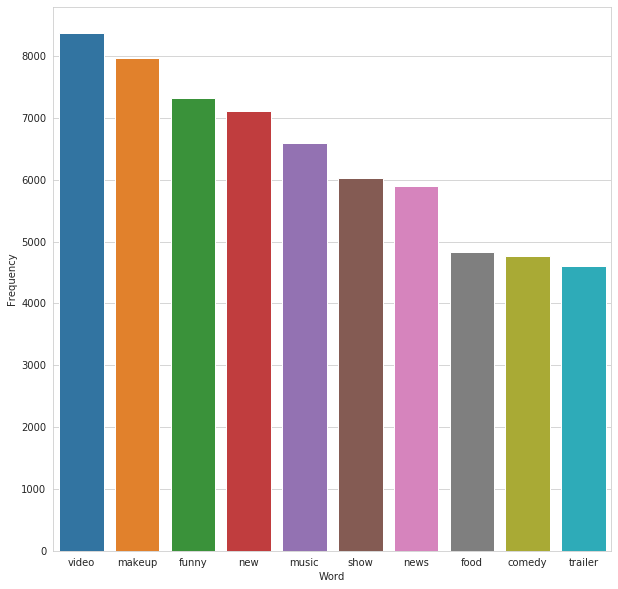

In [13]:
%%local
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data = us_top10_tags)

In [14]:
%%spark -o tags_polarity_df -n 50000
tags_polarity_df, count_string = us_data.get_tags_polarity()
tags_polarity_df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

48137

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Sentiment    48137
dtype: int64


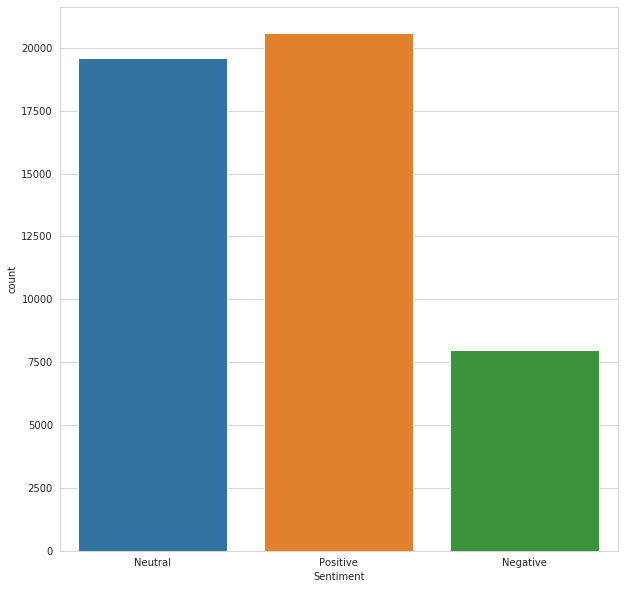

In [15]:
%%local
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
print(tags_polarity_df.count())
ax = sns.countplot(x="Sentiment", data=tags_polarity_df)

In [17]:
%%spark -o us_top10_titles
us_top10_titles = us_data.get_freq_dist_titles(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

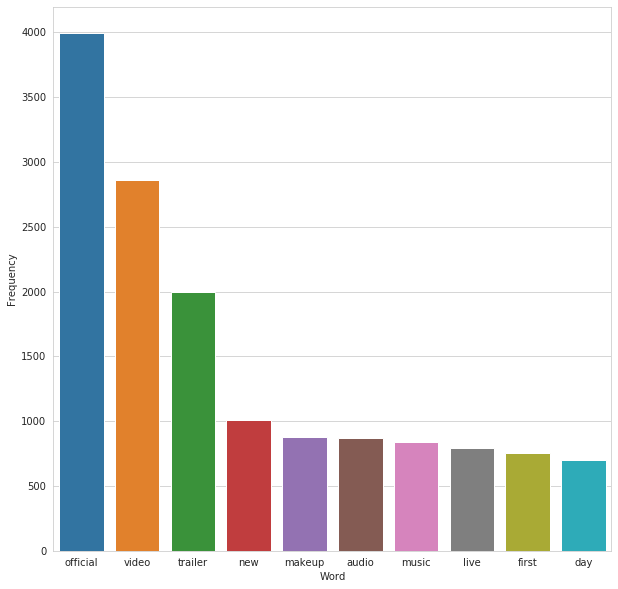

In [18]:
%%local
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data = us_top10_titles)

In [19]:
%%spark -o titles_polarity_df -n 50000
titles_polarity_df, count_string = us_data.get_titles_polarity()
titles_polarity_df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

48137

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Sentiment    48137
dtype: int64


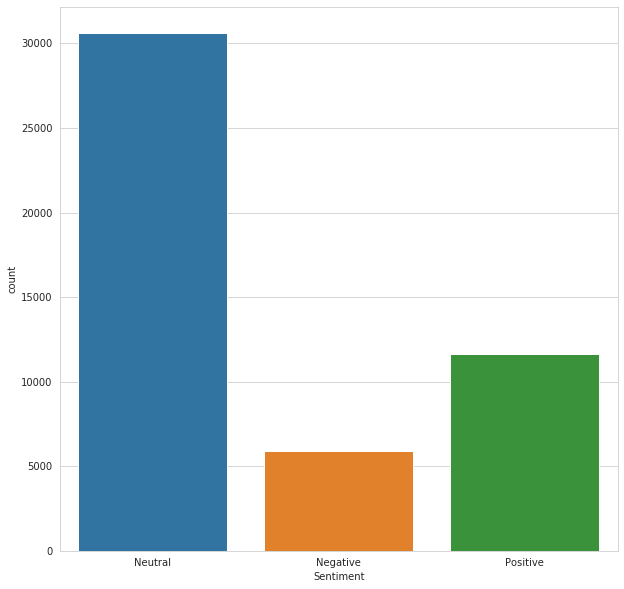

In [20]:
%%local
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
print(titles_polarity_df.count())
ax = sns.countplot(x="Sentiment", data=titles_polarity_df)

In [21]:
%%spark -o us_top10_desc 
us_top10_desc = us_data.get_freq_dist_desc(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

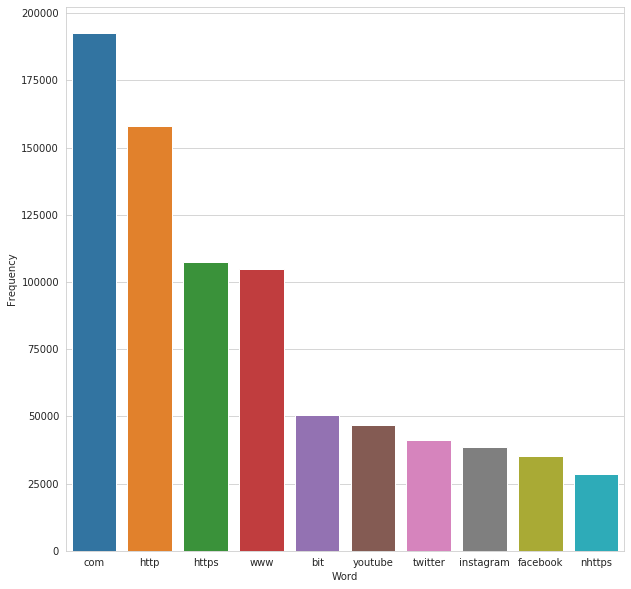

In [23]:
%%local
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data = us_top10_desc)

In [24]:
%%spark -o desc_polarity_df -n 50000
desc_polarity_df, count_string = us_data.get_desc_polarity()
desc_polarity_df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

48137

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Sentiment    48137
dtype: int64


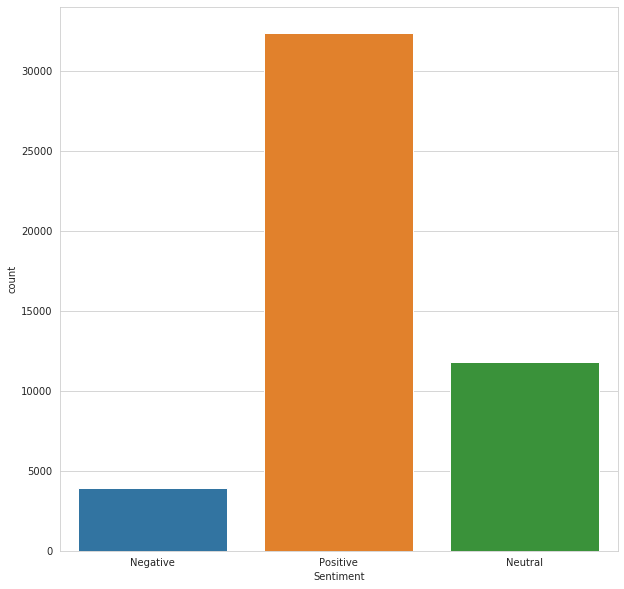

In [25]:
%%local
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
print(desc_polarity_df.count())
ax = sns.countplot(x="Sentiment", data=desc_polarity_df)